<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 20px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 1;">
      <img src="../../utils/risklab_ai.gif" width="100px" style="border: 0; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; font-weight: bold; text-align: left; font-size: 38px;">
      Cross-Validation using Purged K-fold
    </h1>
  </div>  
</div>

This notebook demonstrates how to use the `PurgedKFold` cross-validator from the `RiskLabAI` library to run a robust financial backtest. 

Standard `KFold` cross-validation fails in finance because:
1.  **Leakage:** The training set can contain information that overlaps with the test set (e.g., from overlapping triple-barrier labels).
2.  **Embargo:** Information from the test set can 'leak' back into the training set that follows it.

`PurgedKFold` (De Prado, Chapter 7) solves this by:
1.  **Purging:** Removing any training samples whose labels are concurrent with test set samples.
2.  **Embargoing:** Removing training samples that immediately *follow* the test set to prevent look-ahead bias.

We will:
1.  Load data and generate features/labels.
2.  Define the `event_times` (`t1`) needed for purging.
3.  Instantiate and visualize `PurgedKFold`.
4.  Run a full backtest loop manually (for teaching).
5.  Run a full backtest using the optimized `backtest_predictions` method (recommended).

## 0. Setup and Imports

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
import ta
from ta.utils import dropna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

from RiskLabAI.backtest.validation import CrossValidatorController
import RiskLabAI.utils.publication_plots as pub_plots

In [ ]:
# Global Plotting Settings
SAVE_PLOTS = False  
PLOT_THEME = 'dark' # Options: 'light', 'medium'. 'dark', 'light-transparent', 
PLOT_QUALITY = 300  
SAVE_DIR = 'figs'     

pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving enabled. Saving to: 'figs'


## 1. Load Data & Generate Signals

We will load 'SPY' data and generate some simple features and labels. For this example, we will assume a simple fixed-time horizon label (e.g., 20 days), so our `event_times` (`t1`) will be 20 days after the observation.

In [33]:
import yfinance as yf
import pandas as pd
import ta
from ta.utils import dropna

# --- 1. Load Data ---
ticker_symbol = "SPY"
start_date = "2010-01-01"
end_date = "2025-01-01"

data = yf.Ticker(ticker_symbol).history(
    start=start_date, 
    end=end_date, 
    auto_adjust=True
)

# --- CRITICAL FIX: Remove timezone information ---
# yfinance returns tz-aware indices, which conflict with tz-naive DateOffsets.
data.index = data.index.tz_localize(None)
# ------------------------------------------------

# --- 2. Generate Features (X) ---
X = pd.DataFrame(index=data.index)
X['rsi'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
X['roc'] = ta.momentum.ROCIndicator(data['Close'], window=10).roc()

# --- 3. Generate Labels (y) ---
look_forward = 20
y = data['Close'].pct_change(look_forward).shift(-look_forward)
y = pd.Series((y > 0).astype(int), name='label')

# --- 4. Define Event Times (t1) ---
# The label's 'end time' is 20 days after the observation.
event_times = pd.Series(y.index, index=y.index).apply(lambda x: x + pd.DateOffset(days=look_forward))

# --- 5. Align Data ---
# Combine all data and drop NaNs to ensure X, y, and t1 are aligned
all_data = pd.concat([X, y, event_times.rename('t1')], axis=1).dropna()

X = all_data.drop(columns=['label', 't1'])
y = all_data['label']
event_times = all_data['t1']

print(f"--- SPY (ETF) Data Loaded (TZ-Naive) ---")
print(f"Aligned data shapes: X={X.shape}, y={y.shape}, t1={event_times.shape}")
print(X.head())

--- SPY (ETF) Data Loaded (TZ-Naive) ---
Aligned data shapes: X=(3761, 2), y=(3761,), t1=(3761,)
                  rsi       roc
Date                           
2010-01-22  27.005774 -4.361123
2010-01-25  31.251097 -4.189587
2010-01-26  29.721982 -4.724155
2010-01-27  33.673080 -3.369698
2010-01-28  29.364968 -5.278299


## 2. Visualizing Purged K-Fold Splits

Before we run the backtest, let's visualize how `PurgedKFold` creates its splits. We'll use a `n_splits=10`.

Notice how the **Train** (blue) bar is 'purged' (stops early) before the **Test** (red) bar begins, and an 'embargo' (a gap) is left after the test bar ends. This prevents any information leakage.

Figure saved to: figs\purged_kfold_visualization.png


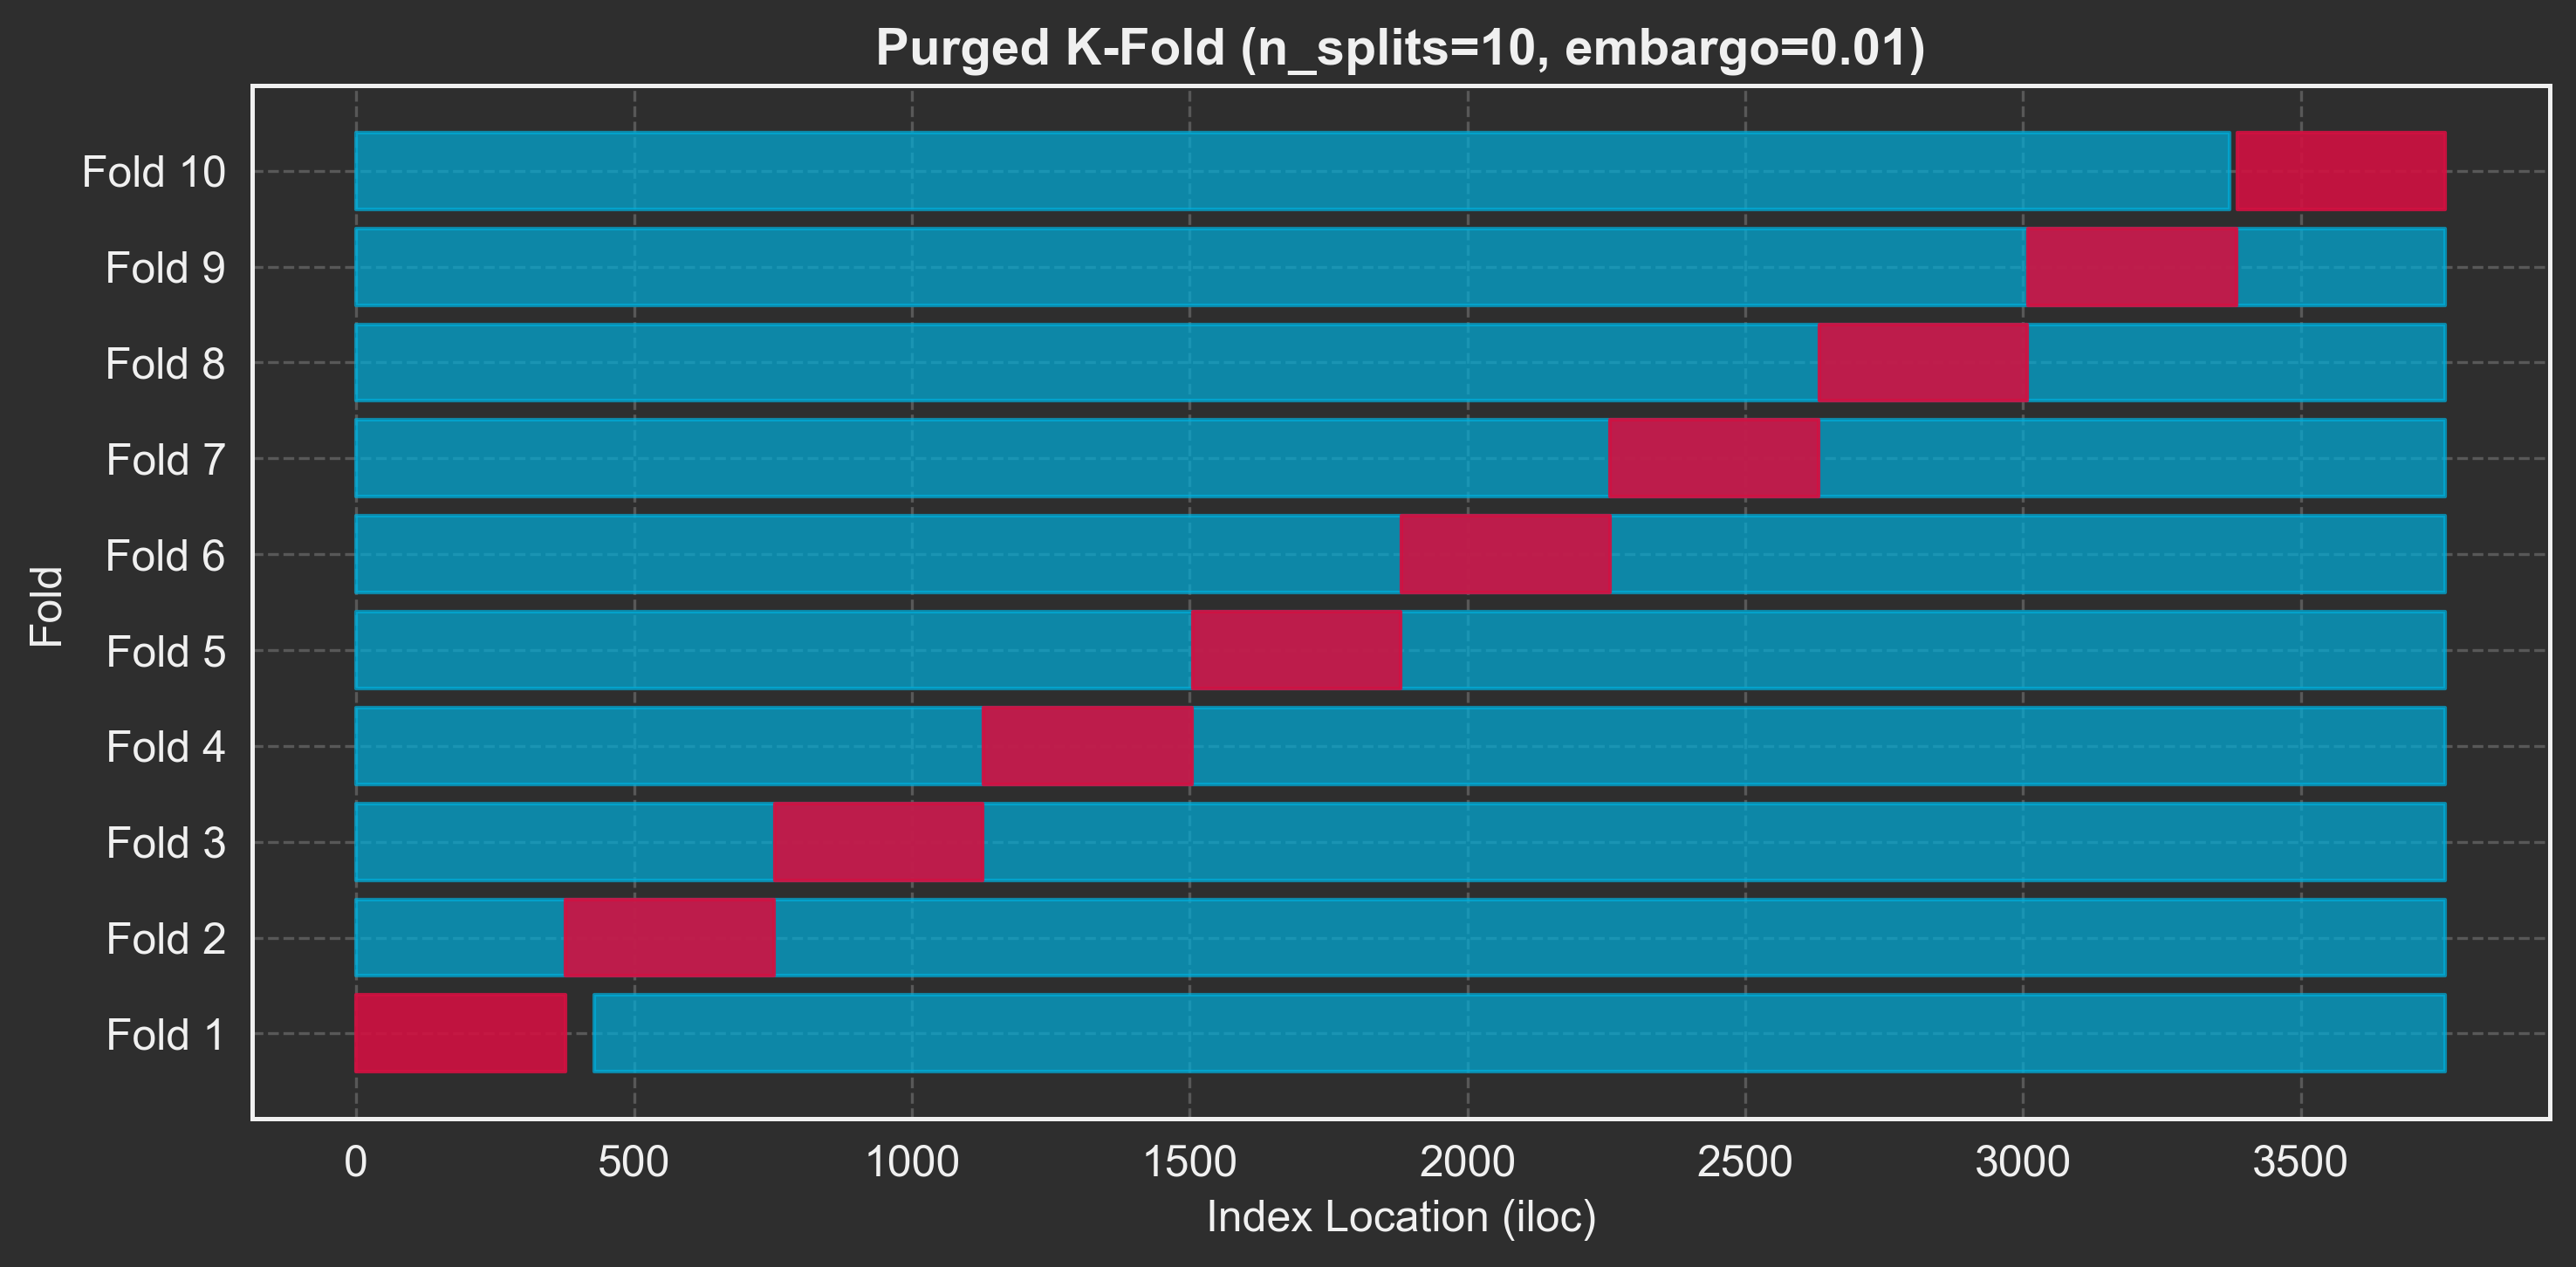

In [34]:
n_splits = 10
embargo_pct = 0.01 # 1% embargo

# --- NEW: Use the CrossValidatorController for easy instantiation ---
cv_controller = CrossValidatorController(
    validator_type='purgedkfold',
    n_splits=n_splits,
    times=event_times,
    embargo=embargo_pct
)
cv = cv_controller.get_validator()
# -------------------------------------------------------------------

# --- Plotting the CV splits --- 
fig, ax = plt.subplots(figsize=(10, 5))
fold_indices = range(n_splits)

for i, (train_idx, test_idx) in enumerate(cv.split(X)):
    # Plot training indices
    ax.fill_betweenx(
        [i-0.4, i+0.4], 
        train_idx.min(), 
        train_idx.max(), 
        color='#00aedb', 
        alpha=0.7, 
        label='Train' if i == 0 else "_nolegend_"
    )
    
    # Plot testing indices
    ax.fill_betweenx(
        [i-0.4, i+0.4], 
        test_idx.min(), 
        test_idx.max(), 
        color='#d11141', 
        alpha=0.9, 
        label='Test' if i == 0 else "_nolegend_"
    )

# Set the y-ticks manually (this is data-specific, not styling)
ax.set_yticks(fold_indices)
ax.set_yticklabels([f'Fold {i+1}' for i in fold_indices])

# Apply the standard styling from your module
pub_plots.apply_plot_style(
    ax=ax,
    title=f'Purged K-Fold (n_splits={n_splits}, embargo={embargo_pct})',
    xlabel='Index Location (iloc)',
    ylabel='Fold', # We can add a ylabel
    legend_title=None # The legend doesn't need a title
)

# Ensure layout is tight before finalizing
plt.tight_layout()

# Finalize (show and/or save) the plot
pub_plots.finalize_plot(fig, 'purged_kfold_visualization.png')

## 3. Backtesting with a Manual Loop (Tutorial Method)

This is the core of the tutorial. We loop through each (train, test) split generated by `cv.split()`:
1.  Train a `RandomForestClassifier` on the **training data**.
2.  Generate predictions on the **testing data**.
3.  Store these out-of-sample (OOS) predictions.

After the loop, we will have a complete set of OOS predictions for our entire dataset, which we can then score.

In [35]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
oos_predictions_manual = pd.Series(index=y.index, dtype=float)

print("Running manual backtest loop...")

# 1. Create the loop iterator
fold_iterator = cv.split(X)

# 2. Wrap the iterator with tqdm
progress_bar = tqdm(enumerate(fold_iterator), total=n_splits, desc="Backtest Fold")

# 3. Loop as normal
for fold, (train_idx, test_idx) in progress_bar:
    # Get data for this fold
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    
    # 1. Train the model
    model.fit(X_train, y_train)
    
    # 2. Generate predictions
    y_pred = model.predict(X_test)
    
    # 3. Store OOS predictions
    oos_predictions_manual.iloc[test_idx] = y_pred

    # --- NEW: Update the progress bar's description ---
    progress_bar.set_postfix({
        "Train Samples": len(X_train),
        "Test Samples": len(X_test)
    })

print("\nBacktest complete.")

Running manual backtest loop...


Backtest Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Backtest complete.


## 4. Evaluate OOS Accuracy

Now we can compare our complete set of OOS predictions against the true labels.

In [36]:
# Drop NaNs from predictions (for any indices that were not in a test set)
oos_predictions_manual = oos_predictions_manual.dropna()
y_true_manual = y.loc[oos_predictions_manual.index]

accuracy_manual = accuracy_score(y_true_manual, oos_predictions_manual)

print(f"Manual Loop OOS Accuracy: {accuracy_manual * 100:.2f}%")

Manual Loop OOS Accuracy: 60.17%


## 5. Backtesting with `backtest_predictions`

The manual loop above is good for understanding the *process*, but your `RiskLabAI` library provides a much faster, optimized, and parallelized method: `backtest_predictions`.

This single function call does the entire loop for you, running the model training in parallel.

In [37]:
print("Running optimized backtest using 'backtest_predictions'...")

# 1. Define a new model instance
model_optimized = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Run the backtest (this handles the loop + parallelization)
path_predictions = cv.backtest_predictions(
    estimator=model_optimized,
    data=X,
    labels=y,
    n_jobs=-1 # Use all available CPU cores
)

print("Optimized backtest complete.")

# For standard K-Fold, predictions are in 'Path 1'
oos_predictions_optimized = pd.Series(path_predictions['Path 1'], index=X.index)


Running optimized backtest using 'backtest_predictions'...
Optimized backtest complete.


In [38]:
# 4. Evaluate the optimized results
oos_predictions_optimized = oos_predictions_optimized.dropna()
y_true_optimized = y.loc[oos_predictions_optimized.index]

accuracy_optimized = accuracy_score(y_true_optimized, oos_predictions_optimized)

print(f"Optimized Method OOS Accuracy: {accuracy_optimized * 100:.2f}%")

# 5. Verify results are identical
if np.isclose(accuracy_manual, accuracy_optimized):
    print("\nSuccess! Both methods produced the same result.")
else:
    print("\nWarning: Results do not match.")

Optimized Method OOS Accuracy: 60.17%

Success! Both methods produced the same result.


## 5. Getting Path Indices

If you just want the *indices* for all splits (like the ones we plotted) without running predictions, you can use the `backtest_paths` method.

In [39]:
paths = cv.backtest_paths(X)

print(f"Path Keys: {paths.keys()}")
print(f"Number of splits in 'Path 1': {len(paths['Path 1'])}")
print("\nExample (first split, 'Train' indices):")
print(paths['Path 1'][0]['Train'][:10])
print("\nExample (first split, 'Test' indices):")
print(paths['Path 1'][0]['Test'][:10])

Path Keys: dict_keys(['Path 1'])
Number of splits in 'Path 1': 10

Example (first split, 'Train' indices):
[428 429 430 431 432 433 434 435 436 437]

Example (first split, 'Test' indices):
[0 1 2 3 4 5 6 7 8 9]
